c:\Users\Ogata\miniconda3\envs\mhitorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(80, 51, 6) (80, 51, 3, 64, 64)
Load Data done
model_path: D:/logs/stereo/20220615_235225/models/model_1000.pth
Start online prediction


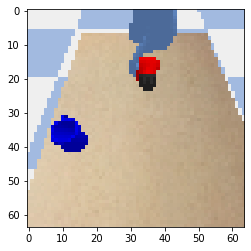

In [1]:
import pybullet as p
import pybullet_data
import numpy as np
import math
import datetime, time, json, os, csv
import torch
import torch.nn as nn
import pandas as pd
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from model.stereo_hiruma import stereo_hiruma_att
from utils import csv_norm, img_norm, draw_subplot
from create_dataset import image_output, calculate_xy

import PIL
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.animation as anm

class dataset(Dataset):
    def __init__(self,left, right, pos):
        self.left = left
        self.right = right
        self.pos = pos
        assert self.left.shape[0] == self.pos.shape[0] == self.right.shape[0]

    def __len__(self):
        return self.pos.shape[0]

    def __getitem__(self, idx):
        return self.left[idx],self.right[idx],self.pos[idx]

data_id = '20220615_170802'
train_dir ='D:/data/normalize/{}/train/'.format(data_id)
test_dir = 'D:/data/normalize/{}/test/'.format(data_id)

train_csv = np.load(os.path.join(train_dir,'joint.npy'))
test_csv = np.load(os.path.join(test_dir,'joint.npy'))
train_left = np.load(os.path.join(train_dir,'left_img.npy'))
train_right = np.load(os.path.join(train_dir,'right_img.npy'))
test_left = np.load(os.path.join(test_dir,'left_img.npy'))
test_right = np.load(os.path.join(test_dir,'right_img.npy'))

plt.imshow(train_left[0][0].transpose(1,2,0))
print(train_csv.shape, train_left.shape)

train_dataset = dataset(train_left, train_right, train_csv)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=True)
test_dataset = dataset(test_left, test_right, test_csv)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
print("Load Data done")

# model path
training_id = "20220615_235225"
model_path = 'D:/logs/stereo/%s/models/model_1000.pth'%(training_id)
print("model_path:", model_path)

# load model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = stereo_hiruma_att(device)
model.load_state_dict(torch.load(model_path,map_location=device))
model.to(device)
model.eval()
criterion = torch.nn.L1Loss()
loss_coef = [1.0, 0.1, 0.001, 0.0001]
print('Start online prediction')


# randm seed
seed = 42
np.random.seed(seed)  # Numpy module.
torch.manual_seed(seed) # 为CPU设置随机种子
torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [98]:
# env setting
train_x = [0.35, -0.35]
train_y = [0.8, 1.0]
test_x1 = [0., 0.125, -0.125]
test_y1 = [1.0]
test_x2 = [-0.175]#[0.35, -0.35, 0., 0.175, -0.175]
test_y2 = [0.9]

all_rz = [-0.78539, -0.39270, 0., 0.39270, 0.78539]

mode = 2
if mode == 0:
    x = np.random.choice(train_x,1).squeeze() + np.random.uniform(-1, 1) * 0.01
    y = np.random.choice(train_y,1).squeeze() + np.random.uniform(-1, 1) * 0.01
    rz = np.random.choice(all_rz,1).squeeze() + np.random.uniform(-1, 1) * 0.002
if mode == 1:
    x = np.random.choice(test_x1,1).squeeze() +np.random.uniform(-1, 1) * 0.01
    y = np.random.choice(test_y1,1).squeeze() + np.random.uniform(-1, 1) * 0.01
    rz = np.random.choice(all_rz,1).squeeze() + np.random.uniform(-1, 1) * 0.002
if mode == 2:
    x = np.random.choice(test_x2,1).squeeze() + np.random.uniform(-1, 1) * 0.01
    y = np.random.choice(test_y2,1).squeeze() + np.random.uniform(-1, 1) * 0.01
    rz = np.random.choice(all_rz,1).squeeze() + np.random.uniform(-1, 1) * 0.002

# pybullet
p.connect(p.DIRECT)
p.resetSimulation()
p.setAdditionalSearchPath(pybullet_data.getDataPath()) # load pybullet data path
p.setGravity(0, 0, 0) # set gravity

# object
planeID = p.loadURDF("plane.urdf")
robotId = p.loadSDF("kuka_iiwa/model.sdf")
tableId = p.loadURDF("table/table.urdf")
boxId = p.loadURDF("objects/mug.urdf", globalScaling=1.3)
robotStartPos = [0.0000, 0.0000, 0.6500]
robotStartOrn = p.getQuaternionFromEuler([0,0,0])

p.resetBasePositionAndOrientation(robotId[0],robotStartPos,robotStartOrn)

tableStartPos = [0.8000, 0., -0.0600]
tableStartOrn = p.getQuaternionFromEuler([0,0,0])
p.resetBasePositionAndOrientation(tableId,tableStartPos,tableStartOrn)

boxStartPos = [y, x, 0.6000]
boxStartOrn = [0.0000, 0.0000, rz]
p.resetBasePositionAndOrientation(boxId,boxStartPos,p.getQuaternionFromEuler(boxStartOrn))

# calculate move plane
p.getNumJoints(robotId[0]) # get joint num
p.getJointInfo(robotId[0], 6) # get joint inf
robotStartPos = [0.6500, 0.0000, 0.6500]
robotStartOrn = [1.5707965, 3.141593, 1.5707965]
objX, objY = calculate_xy(boxStartOrn[2], boxStartPos[0], boxStartPos[1])
robotEndPos = [objY-0.01, objX, 0.6500]
robotEndOrn = [1.5707965, 3.141593, boxStartOrn[2]+1.5707965]

startPos_array = np.array(robotStartPos)
endPos_array = np.array(robotEndPos)
startPos_array = np.array(robotStartPos)
startOrn_array = np.array(robotStartOrn)

targetPositionsJoints = p.calculateInverseKinematics(robotId[0], 6, startPos_array,\
    targetOrientation=p.getQuaternionFromEuler(startOrn_array))# IK
p.setJointMotorControlArray(robotId[0], range(7), p.POSITION_CONTROL,\
        targetPositions=targetPositionsJoints) # move plan


# Initializing
for i in range(50):
    #print(i, "step")
    robotStepPos = list(startPos_array) # next position
    robotStepOrn = list(startOrn_array)
    targetPositionsJoints = p.calculateInverseKinematics(robotId[0], 6, robotStepPos,\
        targetOrientation=p.getQuaternionFromEuler(robotStepOrn))# IK
    p.setJointMotorControlArray(robotId[0], range(7), p.POSITION_CONTROL,\
        targetPositions=targetPositionsJoints) # move plan
    # for i in range(10): #time
    p.stepSimulation()
    #time.sleep(1/240)
#p.disconnect()
result_id = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

In [99]:
init_array =np.concatenate([startPos_array ,startOrn_array],axis=0)
true_value =np.concatenate([robotEndPos ,robotEndOrn],axis=0)
print("init_array",init_array)
print("True_array", true_value)
init_array = torch.from_numpy(csv_norm(np.expand_dims(init_array,axis=0),mode=0)).float().to(device)
input_image = []
pred_image = []
pred_pos = []
map_list1 = []
map_list2 = []
robot_rows = []
history = []
step = 60
rnn_hidden = None
ratio = 0.5
for i in range(step):
    left, right = image_output()
    left = torch.from_numpy(img_norm(left)).permute(2,0,1).unsqueeze(0).to(device)
    right = torch.from_numpy(img_norm(right)).permute(2,0,1).unsqueeze(0).to(device)
    if i <3:
        #history.append(init_array)
        pred_left, pred_right, pred_position, map1, map2,t_pt, pt, rnn_hidden = model(left, right, init_array, rnn_hidden)
        history.append(pred_position)
        input_image.append(np.concatenate([left[0].cpu().detach().numpy(), right[0].cpu().detach().numpy()],axis=2))
        pred_image.append(np.concatenate([pred_left[0].cpu().detach().numpy(), pred_right[0].cpu().detach().numpy()],axis=2))
        pred_pos.append(pred_position[0].cpu().detach().numpy())
        map1 = map1.view(-1, 4, 58, 58)
        map2 = map2.view(-1, 4, 58, 58)
        map_list1.append(map1[0].cpu().detach().numpy())
        map_list2.append(map2[0].cpu().detach().numpy())
        p.stepSimulation()
        time.sleep(1/60)
    else:
        pred_position = ratio * history[i-2] + (1 - ratio) * history[i-3]
        pred_left, pred_right, pred_position, map1, map2,t_pt, pt, rnn_hidden = model(left, right, pred_position, rnn_hidden)
        history.append(pred_position)
        input_image.append(np.concatenate([left[0].cpu().detach().numpy(), right[0].cpu().detach().numpy()],axis=2))
        pred_image.append(np.concatenate([pred_left[0].cpu().detach().numpy(), pred_right[0].cpu().detach().numpy()],axis=2))
        pred_pos.append(pred_position[0].cpu().detach().numpy())
        map1 = map1.view(-1, 4, 58, 58)
        map2 = map2.view(-1, 4, 58, 58)
        map_list1.append(map1[0].cpu().detach().numpy())
        map_list2.append(map2[0].cpu().detach().numpy())
        robot_position = csv_norm(pred_position.cpu().detach().numpy(), mode=1)
        robot_pos = robot_position[0][:3]
        robot_orn = robot_position[0][3:]

        robotStepPos = list(np.round(robot_pos,8))
        robotStepOrn = list(np.round(robot_orn,8))
        robot_rows.append(robotStepPos + robotStepOrn)
        #print("step:",i, "getL:", robot_rows[i])
        targetPositionsJoints = p.calculateInverseKinematics(robotId[0], 6, robotStepPos,\
            targetOrientation=p.getQuaternionFromEuler(robotStepOrn))# IK
        p.setJointMotorControlArray(robotId[0], range(7), p.POSITION_CONTROL,\
                targetPositions=targetPositionsJoints) # move plan
        p.stepSimulation()
        time.sleep(1/60)
p.disconnect()
print("pred_array",robot_position[0])

input_image = np.array(input_image)
pred_image = np.array(pred_image)
pred_pos = np.array(pred_pos)
map_list1 = np.array(map_list1)
map_list2 = np.array(map_list2)
print(input_image.shape, pred_image.shape, pred_pos.shape, map_list1.shape)

init_array [0.65      0.        0.65      1.5707965 3.141593  1.5707965]
True_array [ 0.70789776 -0.22920968  0.65        1.5707965   3.141593    1.56959187]
pred_array [ 0.6426638  -0.15734571  0.649999    1.5707748   3.1415398   1.6249075 ]
(60, 3, 64, 128) (60, 3, 64, 128) (60, 6) (60, 4, 58, 58)


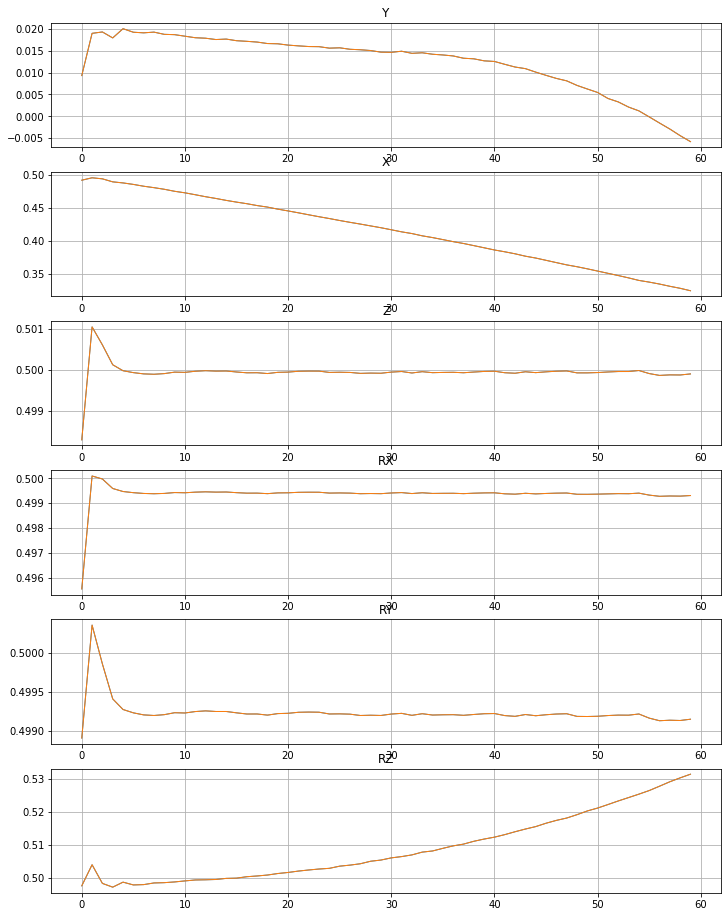

In [100]:
xyz=["Y","X","Z","RX","RY","RZ"]
plt.figure(figsize=(12,16))
steps = range(len(pred_pos))
for i in range(6):
    pred_one_position = np.concatenate((pred_pos[:,i].reshape(-1,1),pred_pos[:,i].reshape(-1,1)), axis=1)
    draw_subplot(steps, pred_one_position, (6,1,i+1), title=xyz[i])
plt.savefig('result/{}.pdf'.format(result_id))
plt.savefig('result/{}.png'.format(result_id))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

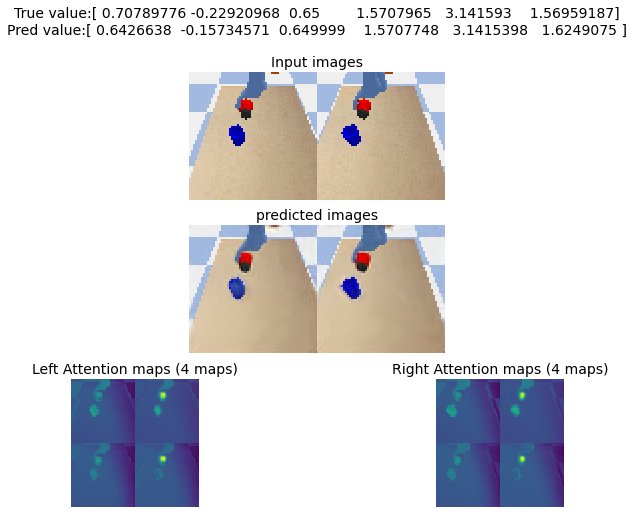

In [101]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.animation as anim
figure = plt.figure(figsize=(12, 8))
#plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
gs_master = GridSpec(nrows=3, ncols=2, height_ratios=[1, 1, 1], width_ratios=[1, 1])

gs_1 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[0, :])
axes_1 = figure.add_subplot(gs_1[:, :])
axes_1.set_title("True value:{}\nPred value:{}\n\nInput images".format(true_value,robot_position[0]), fontsize = 14)
axes_1.set_axis_off()

gs_3 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[1, :])
axes_3 = figure.add_subplot(gs_3[:, :])
axes_3.set_title("predicted images", fontsize = 14)
axes_3.set_axis_off()

gs_5 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[2, 0])
axes_5 = figure.add_subplot(gs_5[:, :])
axes_5.set_title("Left Attention maps (4 maps)", fontsize = 14)
axes_5.set_axis_off() 

gs_6 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[2, 1])
axes_6 = figure.add_subplot(gs_6[:, :])
axes_6.set_title("Right Attention maps (4 maps)", fontsize = 14)
axes_6.set_axis_off() 

def anim_update(i):
        
        left_attmap = np.array(map_list1)
        right_attmap = np.array(map_list2)

        axes_1.imshow(input_image[i].transpose(1,2,0),interpolation='nearest')
     
        axes_3.imshow(pred_image[i].transpose(1,2,0),interpolation='nearest')
     

        left_up = np.concatenate([left_attmap[i][0], left_attmap[i][1]], axis=1)
        left_down = np.concatenate([left_attmap[i][2], left_attmap[i][3]], axis=1)
        left_sum = np.concatenate([left_up, left_down], axis=0)

        right_up = np.concatenate([right_attmap[i][0], right_attmap[i][1]], axis=1)
        right_down = np.concatenate([right_attmap[i][2], right_attmap[i][3]], axis=1)
        right_sum = np.concatenate([right_up, right_down], axis=0)

        axes_5.imshow(left_sum,interpolation='nearest')
        axes_6.imshow(right_sum,interpolation='nearest')
ani = anm.FuncAnimation(figure, anim_update, interval=100, frames=step)
ani.save('result/{}.gif'.format(result_id),writer = 'pillow')